Training: 100%|██████████| 60000/60000 [43:05<00:00, 23.20episode/s, Avg Reward (last 10 episodes)=3.19e+3] 


Rewards history saved
Saved shared policy to shared_policy_sumdiff.pth


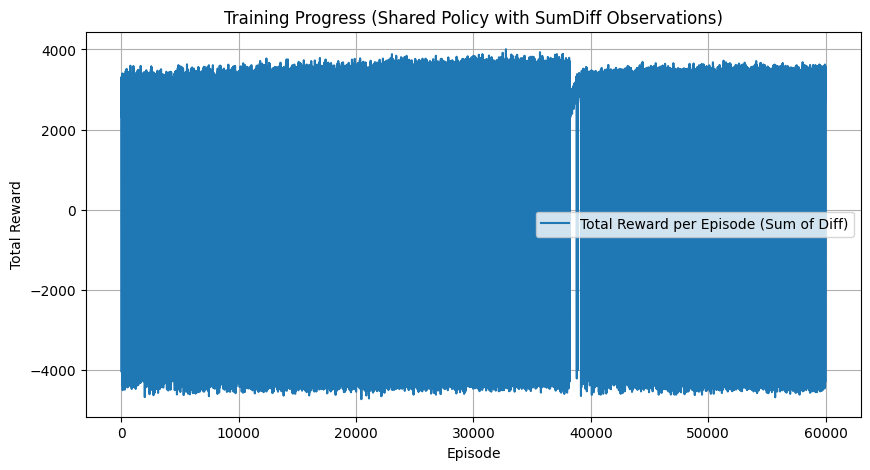

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# 假设所有Agent的观测维度和动作维度相同
class PolicyNetwork(nn.Module):
    """
    与之前的网络类似，只是这里输入层大小是1(由env决定)。
    也可以保持和之前相同的结构，只要 input_dim=1 即可。
    """
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits


def train_multiagent(env, num_episodes=3000, gamma=0.99, lr=0.001, reward_threshold=6500):
    """
    使用REINFORCE算法的多智能体训练，每个智能体的策略网络参数共享。
    假设环境里每个智能体的观测空间大小相同、动作空间大小相同。
    """

    # 获取agents列表
    agents = env.agents
    # 以第一个智能体的观测和动作空间来初始化共享网络
    obs_dim = env.observation_space(agents[0]).shape[0]  # 这里会是1
    act_dim = env.action_space(agents[0]).n              # 2

    # 创建一个共享策略网络
    shared_policy = PolicyNetwork(obs_dim, act_dim)
    # 创建一个优化器
    optimizer = optim.Adam(shared_policy.parameters(), lr=lr)

    total_rewards_history = []

    # 进度条
    progress_bar = tqdm(range(num_episodes), desc="Training", unit="episode")
    for episode in progress_bar:
        # reset返回的是一个字典 {agent: obs}
        obs = env.reset()
        dones = {agent: False for agent in agents}
        done_flag = False

        # 收集一个episode里所有agent的轨迹
        trajectories = {agent: {"obs": [], "actions": [], "rewards": []} for agent in agents}

        while not done_flag:
            actions = {}
            # 对每个agent单独决策
            for agent in agents:
                obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)  # shape: (1,1)
                with torch.no_grad():
                    logits = shared_policy(obs_tensor)
                probs = torch.softmax(logits, dim=-1)
                action = torch.multinomial(probs, 1).item()
                actions[agent] = action
            
            # 与环境交互
            next_obs, rewards, dones, infos = env.step(actions)
            
            # 记录数据
            for agent in agents:
                trajectories[agent]["obs"].append(obs[agent])       # shape(1,)
                trajectories[agent]["actions"].append(actions[agent])
                trajectories[agent]["rewards"].append(rewards[agent])
            
            obs = next_obs
            done_flag = all(dones.values())
        
        # 一回合结束后，计算REINFORCE的loss并更新
        optimizer.zero_grad()
        total_loss = 0.0

        for agent in agents:
            # 计算该智能体在本episode中的折扣回报
            returns = []
            G = 0
            for r in reversed(trajectories[agent]["rewards"]):
                G = r + gamma * G
                returns.insert(0, G)
            
            # 做前向传播
            obs_batch = torch.FloatTensor(trajectories[agent]["obs"])         # shape: (T,1)
            action_batch = torch.LongTensor(trajectories[agent]["actions"])   # shape: (T,)
            return_batch = torch.FloatTensor(returns)                         # shape: (T,)

            logits = shared_policy(obs_batch)             # shape: (T, act_dim)
            log_probs = torch.log_softmax(logits, dim=-1) # shape: (T, act_dim)
            # 取对应动作的log_prob
            chosen_log_probs = log_probs.gather(1, action_batch.unsqueeze(1)).squeeze(1)  # shape: (T,)

            # REINFORCE的目标： - E[ G_t * log pi(a_t|s_t) ]
            loss = -(chosen_log_probs * return_batch).mean()
            total_loss += loss

        total_loss.backward()
        optimizer.step()

        # 记录本episode的所有智能体总奖励
        total_reward_this_episode = sum([sum(trajectories[agent]["rewards"]) for agent in agents])
        total_rewards_history.append(total_reward_this_episode)

        # 进度条显示最近10个episode的平均回报
        if episode % 10 == 0:
            avg_reward = np.mean(total_rewards_history[-10:]) if len(total_rewards_history) >= 10 else total_reward_this_episode
            progress_bar.set_postfix({"Avg Reward (last 10 episodes)": avg_reward})

        # 若达到阈值可以打印或提前停止
        if total_reward_this_episode >= reward_threshold:
            print(f"Episode {episode} 达到回报阈值，动作序列示例：")
            break

    return total_rewards_history, shared_policy


if __name__ == "__main__":
    # 引入你新改的环境
    from env_new.MAenv_sum import CustomMAEnvironmentSumDiff

    # 创建环境
    env = CustomMAEnvironmentSumDiff(num_agents=5, num_iterations=200, dt=0.1)
    
    # 开始训练
    rewards_history, shared_policy = train_multiagent(
        env, 
        num_episodes=60000, 
        gamma=0.99, 
        lr=0.001,
        reward_threshold=8500
    )
    
    # 保存训练曲线
    np.save("rewards_history_sumdiff.npy", rewards_history)
    print("Rewards history saved")

    # 仅保存一个共享策略网络
    torch.save(shared_policy.state_dict(), "shared_policy_sumdiff.pth")
    print("Saved shared policy to shared_policy_sumdiff.pth")

    # 绘制总体回报曲线
    plt.figure(figsize=(10,5))
    plt.plot(rewards_history, label="Total Reward per Episode (Sum of Diff)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress (Shared Policy with SumDiff Observations)")
    plt.legend()
    plt.grid(True)
    plt.show()


Rewards history loaded successfully.
Top 1: Reward = 4006.62, Step = 32770
Top 2: Reward = 3933.98, Step = 35671
Top 3: Reward = 3918.62, Step = 32495
Top 4: Reward = 3888.4700000000003, Step = 37599
Top 5: Reward = 3884.9799999999996, Step = 37100
Top 6: Reward = 3884.88, Step = 30770
Top 7: Reward = 3884.5699999999997, Step = 37626
Top 8: Reward = 3883.64, Step = 23063
Top 9: Reward = 3876.04, Step = 33234
Top 10: Reward = 3872.23, Step = 37586


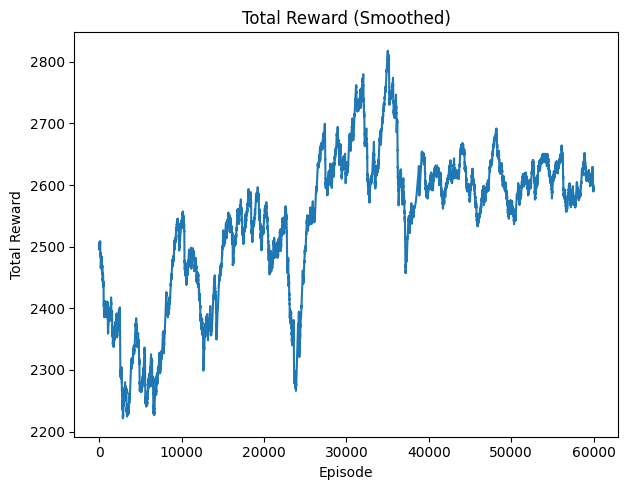

In [10]:

import numpy as np

# 加载 total_rewards_history 文件
loaded_rewards_history = np.load("rewards_history_sumdiff.npy")
print("Rewards history loaded successfully.")
# 使用平滑函数对数据进行平滑处理


# 找到前十最大的值及其对应的时间步
top_10_indices = np.argsort(loaded_rewards_history)[-10:][::-1]  # 按降序排列的索引
top_10_rewards = loaded_rewards_history[top_10_indices]  # 对应的奖励值

# 打印前十的值及其时间步
for i, (reward, step) in enumerate(zip(top_10_rewards, top_10_indices)):
    print(f"Top {i+1}: Reward = {reward}, Step = {step}")

def smooth(data, weight=0.9995):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_value = last * weight + (1 - weight) * point
        smoothed.append(smoothed_value)
        last = smoothed_value
    return smoothed

# 对奖励历史和Q值历史进行平滑
smoothed_reward_history = smooth(loaded_rewards_history)
#smoothed_q_value_history = smooth(q_value_history)

# 绘制平滑后的曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Total Reward (Smoothed)")
plt.plot(smoothed_reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")


plt.tight_layout()
plt.show()
